In [78]:
import pandas as pd
import os

df_append = pd.DataFrame()

data_path = os.path.join(os.getcwd(),"classifier_data")
for dirName, subdirList, fileList in os.walk(data_path):
    for file in fileList:
        df_temp = pd.read_csv(os.path.join(data_path,file))
        df_append = df_append.append(df_temp, ignore_index = True)

df_append.info()
print(df_append['class'].value_counts)
df_append.to_csv(os.path.join(os.getcwd(),"classifier_data\\combined.csv"),index=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Columns: 141 entries, distance to class
dtypes: float64(140), int64(1)
memory usage: 431.9 KB
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
387    1
388    1
389    1
390    1
391    1
Name: class, Length: 392, dtype: int64>


Determine which files are Os (no accident), which ones are 1s (accident)


In [64]:
import os
import pandas as pd

data_path = os.path.join(os.getcwd(),"features")
zeros = []
ones = []
for dirName, subdirList, fileList in os.walk(data_path):
    for file in fileList:
        df = pd.read_csv(os.path.join(data_path,file),index_col=0)
        if(True in df['intersect'].unique()):
            ones.append(file)
        else:
            zeros.append(file)

print(f"Zeros: {len(zeros)}, {zeros[0]}")
print(f"Ones: {len(ones)}, {ones[0]}")

Zeros: 127, 0_perturbed_1.csv
Ones: 73, 10_vanilla_0.csv


1) For each file, identify the "row of interest" (i.e. where you want to take 3 seconds before from)
2) Now take 3 seconds before, sampling every .5 seconds

In [65]:
sample_interval = 0.5
frame_interval = 0.05
seconds_before = 3
seconds_after = 0

all_files = zeros + ones

all_seqs = []

for file in all_files:
    df = pd.read_csv(os.path.join(data_path,file),index_col=0)
    clazz = None

    #The "event of interest" is:
    #   For '1' paths, when the accident occurs
    
    df_moving = df[20:]
    row_of_interest = None
    if file in ones:
        #find the row number where the accident first occurs
        row_of_interest = df[df['intersect']].iloc[0].name - 1
        clazz = 1
    if file in zeros:
        #find the row number where the lane change occurs
        #where j = 10 (adv_point % 20 == 10)
        df['adv_point'] = df['adv_point'].astype(int)
        try:
            row_of_interest = df[df['adv_point'] % 20 == 12].iloc[0].name - 1
        except IndexError:
            print(f"Removing file:{file}, doesn't meet the criteria")
            all_files.remove(file)
            continue
        clazz = 0
    if(row_of_interest < seconds_before/frame_interval):
        print(f"Removing file:{file}, not enough data")
        all_files.remove(file)
        continue


    start_idx = row_of_interest - seconds_before * (2*sample_interval/frame_interval)
    stop_idx = row_of_interest + seconds_after * (2*sample_interval/frame_interval)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/frame_interval)): indices_to_sample.append(x)

    columns_of_interest = ['distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    try:
        rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    except:
        print(f"bad keys in file {file}")
        print(indices_to_sample)
        continue
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(clazz)
    all_seqs.append(one_seq)



full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * int((len(all_seqs[0])-1)/len(columns_of_interest)) + ['class']))
full_df.to_csv(os.path.join(os.getcwd(),"classifier_data\\labeled_data.csv"),index=None)
full_df.info()

Removing file:88_vanilla_0.csv, doesn't meet the criteria
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Columns: 141 entries, distance to class
dtypes: float64(140), int64(1)
memory usage: 218.2 KB


Generate Train/Test Files

In [72]:
full_df = pd.read_csv(os.path.join(os.getcwd(),"classifier_data\\labeled_data.csv"))
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Columns: 141 entries, distance to class
dtypes: float64(140), int64(1)
memory usage: 431.9 KB


In [73]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv(os.path.join(os.getcwd(),"classifier_data\\train_file.csv"),index=None)
test.to_csv(os.path.join(os.getcwd(),"classifier_data\\test_file.csv"),index=None)

In [74]:
x_train.head()

,distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z.6,adv_vel_x.6,adv_vel_y.6,adv_vel_z.6,adv_accel_x.6,adv_accel_y.6,adv_accel_z.6,adv_ang_vel_x.6,adv_ang_vel_y.6,adv_ang_vel_z.6
331,4.627736,80.566926,-3.828516,0.000563,0.002206,-6.476464,-0.003804,-0.008703,-0.106228,-1.458710,...,0.199280,-5.944576,2.208124,-0.056752,1.272840,-0.714388,-0.013013,-0.445199,-0.835233,5.631906
181,1.393777,-83.044841,-5.747271,-0.000339,-0.007136,-2.601061,0.006383,-0.048254,0.156521,1.060539,...,-34.577267,-5.884548,-1.091117,-0.068156,-2.150860,-0.064485,-0.091414,-0.650232,-1.473426,-6.846320
291,4.196866,174.233422,-5.046963,0.003767,-0.077193,-2.955408,0.003008,0.124514,-0.405801,-3.320619,...,1.444511,-5.649720,2.107539,-0.096841,-0.670881,0.291657,-0.011458,0.066231,0.177690,-0.413979
140,2.398740,-102.932027,-4.913240,-0.000560,-0.050520,-0.974092,0.038501,0.072086,-0.450002,-2.594245,...,0.211420,-8.013268,-2.826033,-0.137811,0.346088,3.712478,0.005363,1.682001,0.108203,-9.128959
328,5.088861,-134.654628,-7.185088,-0.004763,-0.118652,-3.577023,-0.036015,-0.070578,-0.219991,-0.446527,...,0.115177,-9.404526,-3.357208,-0.160739,-2.021141,3.425422,-0.028457,1.673334,0.768149,-10.542345


In [75]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)


0.9923076923076923

In [77]:
#===== RDF
predictions = RF.predict(x_test) #test_features
# Calculate the absolute errors
errors = abs(predictions - y_test) #test_y_ is test_labels
# Print out the mean absolute error (mae)
print('Average absolute error:', round(np.mean(errors), 2), ' %.')
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', round(accuracy, 2))
fp = np.sum((predictions == 1) & (y_test == 0))
tp = np.sum((predictions == 1) & (y_test == 1))
fn = np.sum((predictions == 0) & (y_test == 1))
tn = np.sum((predictions == 0) & (y_test == 0))
tpr = tp / (tp + fn)
print('TPR/Recall:', round(tpr, 2))
tnr = tn / (fp + tn)
print('TNR:', round(tnr, 2))
fnr = fn / (tp + fn)
print('FNR:', round(fnr, 2))
fpr = fp / (fp + tn)
print('FPR:', round(fpr, 2))
#Positive Predictive Value / Precision
ppv = tp / (tp + fp)
print('PPV:', round(ppv, 2))
F1 = 2 * (ppv * tpr) / (ppv + tpr)
print('F1:', round(F1, 2))

Average absolute error: 0.01  %.
Accuracy: 0.99
TPR/Recall: 1.0
TNR: 0.99
FNR: 0.0
FPR: 0.01
PPV: 0.98
F1: 0.99


[(101, 'angle', 0.11488681507566975), (100, 'distance', 0.10853531991352819), (121, 'angle', 0.09071138566261266), (120, 'distance', 0.07527066040450006), (4, 'ego_vel_z', 0.07270276456192681), (80, 'distance', 0.04248595133533245), (13, 'adv_vel_z', 0.04216652736489473), (81, 'angle', 0.04188678563872914), (84, 'ego_vel_z', 0.03964405754421576), (41, 'angle', 0.035888354510986105), (20, 'distance', 0.02795610380840116), (73, 'adv_vel_z', 0.023022722527954006), (24, 'ego_vel_z', 0.021603639672342512), (0, 'distance', 0.021569799745489542), (1, 'angle', 0.02097110857708173), (104, 'ego_vel_z', 0.020008202154939633), (40, 'distance', 0.017618821872500995), (60, 'distance', 0.015282411102584846), (44, 'ego_vel_z', 0.015122375887608366), (93, 'adv_vel_z', 0.012265149010181869)]
31.428571428571427


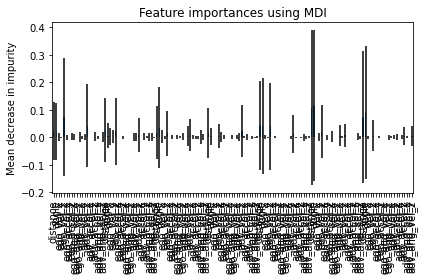

In [50]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1]
sorted_tuple = [(i,feature_names[i],importances[i]) for i in sorted_importances]
print(sorted_tuple[:20])
print(len([x for x in sorted_tuple if x[2]==0])/len(sorted_tuple) * 100)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [53]:
RF.predict(x_test[:4])

array([1, 1, 0, 1], dtype=int64)